Result computation and analysis of MNIST toy experiment. Goal is to see on a toy example how layer rotation affects the features learned by a network.


Experiment info:

1 layer MLP (784 hidden) + batchnorm (batchnorm was used to enable larger layer rotations)  
reduced MNIST dataset (1000 samples per class) (to increase overparametrization)  
Layca as optimization algorithm  
different initial learning rates

In [1]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()

%load_ext autoreload

In [2]:
%autoreload
import sys
sys.path.insert(0, "../")

import warnings
import os
import time

import math as m
import numpy as np
np.random.seed(1)

import matplotlib
import matplotlib.pyplot as plt
import pickle

from keras.layers import Input, Dense, BatchNormalization, Activation
from keras.models import Model
from layca_optimizers import SGD
from keras.callbacks import LearningRateScheduler

from experiment_utils import plot_history, history_todict
from layer_rotation_utils import LayerRotationCurves, plot_layer_rotation_curves
from experiment_utils import lr_schedule

from feature_visualization import visualize_1stlayer_weights
from utils import load_reduced_mnist_data

Using TensorFlow backend.
c:\Users\rjtdu\anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\rjtdu\anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\rjtdu\anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\rjtdu\anaconda3\envs\py36\lib\site-packag

In [3]:
# utilities for storing the results in pickle files
result_file = 'results_cifar_1.p'
def load_results():
    if not os.path.isfile(result_file):
        return {}
    else:
        with open(result_file,'rb') as f:
            return pickle.load(f)

def dump_results(results):
    with open(result_file,'wb') as f:
        pickle.dump(dict(results),f)

def update_results(path, new_data):
    results = load_results()
    position = results
    for p in path:
        position = position[p]
    # new_data is a dictionary with the new (key,value) pairs
    position.update(new_data)
    dump_results(results)
    
# if results should be saved in the file or not
save_results = True
if not save_results:
    results = {}

In [4]:
# ----------------------------------
# 1. Load CIFAR-10 dataset (Reduced)
# ----------------------------------
from keras.datasets import cifar10
from keras.utils import to_categorical
from skimage.color import rgb2gray
from skimage.transform import resize


(x_train, y_train), (x_test, y_test) = cifar10.load_data()


# Reduce dataset size to make training faster
train_samples = 10000
test_samples = 10000
x_train, y_train = x_train[:train_samples], y_train[:train_samples]
x_test, y_test = x_test[:test_samples], y_test[:test_samples]

# Convert to grayscale
x_train = np.expand_dims(rgb2gray(x_train), axis=-1)  # shape: (N, 32, 32, 1)
x_test = np.expand_dims(rgb2gray(x_test), axis=-1)    # shape: (N, 32, 32, 1)

# Resize function for all images
def resize_images(images, new_shape=(28, 28)):
    return np.array([resize(image, new_shape, anti_aliasing=True) for image in images])

# Resize your grayscale images
x_train_resized = resize_images(x_train.squeeze())  # shape: (N, 28, 28)
x_test_resized = resize_images(x_test.squeeze())    # shape: (N, 28, 28)

# Flatten each image
x_train = x_train_resized.reshape((x_train_resized.shape[0], -1))  # shape: (N, 784)
x_test = x_test_resized.reshape((x_test_resized.shape[0], -1))     # shape: (N, 784)


# Flatten each image
x_train = x_train.reshape((x_train.shape[0], -1))  # shape: (N, 32 * 32 * 3)
x_test = x_test.reshape((x_test.shape[0], -1))     # shape: (N, 32 * 32 * 3)


# Normalize data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.


# One-hot encode labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [5]:
print(x_train.shape)
print(y_train.shape)


(10000, 784)
(10000, 10)


In [6]:
def get_model():
    inp = Input((784,))
    x = Dense(784, activation = 'linear', name = 'dense0')(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dense(10, activation = 'softmax', name = 'densef')(x)
    return Model(inp,x)

In [7]:
os.makedirs('saved_weights_cifar1', exist_ok=True)

In [8]:
# !pip install h5py==2.10.0


In [9]:
import h5py
print(h5py.__version__)  # should print 2.10.0


2.10.0


In [10]:
# configuration of the different learning rate schedules 
# (a division of the learning rate by 5 is used to escape plateaus in the loss curve)
training_configs = {3**-2: (100, LearningRateScheduler(lr_schedule(3**-2,1./5.,[90]))),
                    3**-2.5: (100, LearningRateScheduler(lr_schedule(3**-2.5,1./5.,[95]))),
                    3**-3: (100, LearningRateScheduler(lr_schedule(3**-3,1./5.,[95]))),
                    3**-4: (100, LearningRateScheduler(lr_schedule(3**-4,1.,[np.inf]))),
                    3**-5: (120, LearningRateScheduler(lr_schedule(3**-5,1.,[np.inf]))),
                    3**-6: (300, LearningRateScheduler(lr_schedule(3**-6,1.,[np.inf]))),
                    3**-7: (1000, LearningRateScheduler(lr_schedule(3**-7,1.,[np.inf])))}

lrs = [3**-2,3**-3,3**-4, 3**-5]
for lr in lrs:
    model = get_model()

    weights_location = 'saved_weights_cifar1/cifar_initial_weights.h5'
    if not os.path.isfile(weights_location):
        model.save_weights(weights_location)
    else:
        model.load_weights(weights_location)

    epochs = training_configs[lr][0]
    lr_sched = training_configs[lr][1]

    ladc = LayerRotationCurves(batch_frequency = np.inf)

    model.compile(loss='categorical_crossentropy',
                  optimizer=SGD(lr,layca = True),
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train,
                        batch_size=2048,
                        epochs=epochs,
                        verbose=1,
                        validation_data = (x_test,y_test),
                        callbacks = [ladc, lr_sched])


    if save_results:
        update_results([],{lr:{'history':history_todict(history),'ladc':ladc.memory}})
    else:
        results.update({lr:{'history':history_todict(history),'ladc':ladc.memory}})

    if save_results:
        model.save_weights('saved_weights_cifar1/'+str(round(lr,6))[2:]+'.h5')

Train on 10000 samples, validate on 10000 samples
Epoch 1/100
10000/10000 [==============================] - 0s 47us/step - loss: 2.1696 - acc: 0.2117 - val_loss: 2.2943 - val_acc: 0.1029
Epoch 2/100
10000/10000 [==============================] - 0s 43us/step - loss: 2.0481 - acc: 0.2681 - val_loss: 2.2882 - val_acc: 0.1716
Epoch 3/100
10000/10000 [==============================] - 0s 43us/step - loss: 1.9918 - acc: 0.2940 - val_loss: 2.2829 - val_acc: 0.1227
Epoch 4/100
10000/10000 [==============================] - 0s 44us/step - loss: 1.9692 - acc: 0.3035 - val_loss: 2.2859 - val_acc: 0.1146
Epoch 5/100
10000/10000 [==============================] - 0s 44us/step - loss: 1.9458 - acc: 0.3159 - val_loss: 2.2823 - val_acc: 0.1975
Epoch 6/100
10000/10000 [==============================] - 0s 42us/step - loss: 1.9267 - acc: 0.3219 - val_loss: 2.2783 - val_acc: 0.1230
Epoch 7/100
10000/10000 [==============================] - 0s 43us/step - loss: 1.9048 - acc: 0.3226 - val_loss: 2.2765 - 

In [11]:
def get_aspect(ax=None):  # used to compute rotation of text here under
    if ax is None:
        ax = plt.gca()
    fig = ax.figure

    ll, ur = ax.get_position() * fig.get_size_inches()
    width, height = ur - ll
    axes_ratio = height / width
    aspect = axes_ratio / ax.get_data_ratio()

    return aspect

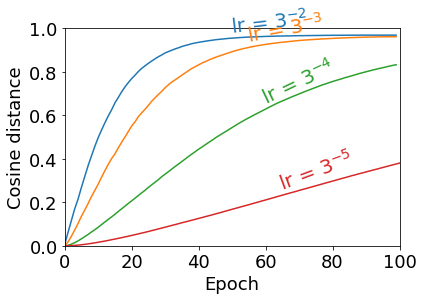

In [12]:
mpld3.disable_notebook()
matplotlib.rcParams.update({'font.size': 18})

lrs = [3**-2,3**-3,3**-4, 3**-5]
lrs_text = ['lr = $3^{-2}$', 'lr = $3^{-3}$', 'lr = $3^{-4}$', 'lr = $3^{-5}$']

results = load_results()
plt.figure()
plt.ylim([0,1])
plt.xlim([0,100])

for i,lr in enumerate(lrs):
    ladc_dense0 = np.array(results[lr]['ladc'])[:,0]
    
    plt.plot(range(len(ladc_dense0)),ladc_dense0)
    
    x_coord = 50+5*i
    diff = 30
    angle = m.atan((ladc_dense0[x_coord+diff]-ladc_dense0[x_coord])/diff*get_aspect())*180/m.pi
    
    plt.annotate(lrs_text[i], xy=(x_coord, ladc_dense0[x_coord]), xycoords='data', color = 'C'+str(i), size = 20,
                 rotation = angle+5, rotation_mode='anchor',
                 xytext = (0,5), textcoords = 'offset points')

plt.xlabel('Epoch')
plt.ylabel('Cosine distance')

plt.savefig('figures/cifar_layer_rotations1.png',format='png', dpi=200, bbox_inches="tight")


In [13]:
lrs = [3**-2,3**-3,3**-4, 3**-5]

results = load_results()
test_performances = []
train_performances = []
for lr in lrs:
    test_performances.append(results[lr]['history']['history']['val_acc'][-1])
    train_performances.append(results[lr]['history']['history']['acc'][-1])
print(test_performances)
print()
print(train_performances)

[0.3441000009536743, 0.35139999766349794, 0.34890000128746035, 0.338700000667572]

[0.38759999737739564, 0.38820000147819517, 0.38499999952316283, 0.3679999998092651]


c:\Users\rjtdu\OneDrive\Desktop\LayerRotation\layer-rotation-paper-experiments\MNIST - 1st layer feature visualization\feature_visualization.py:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  kernel = weights[index].reshape((28,28))


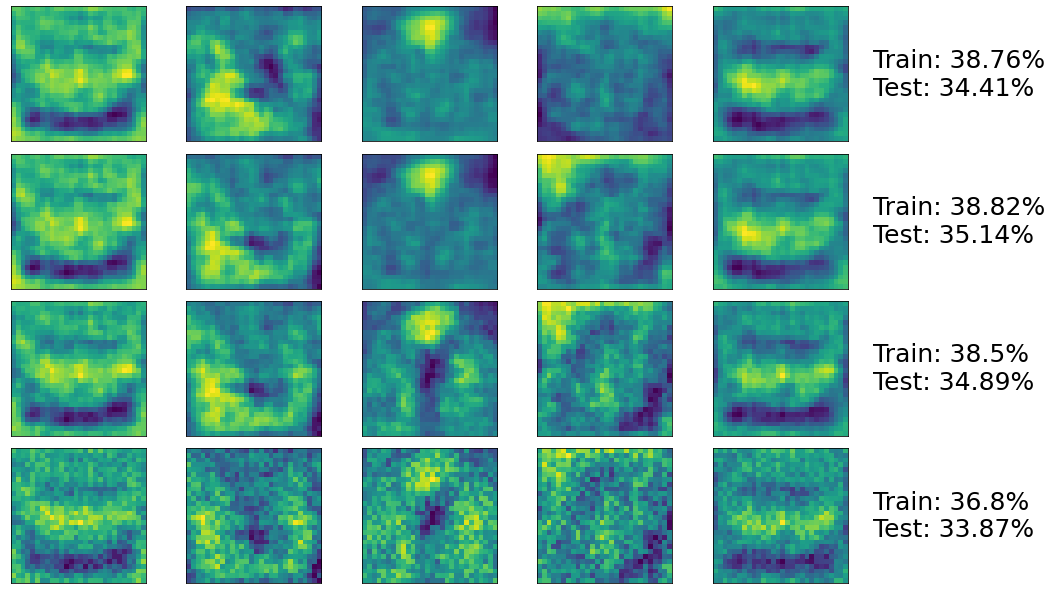

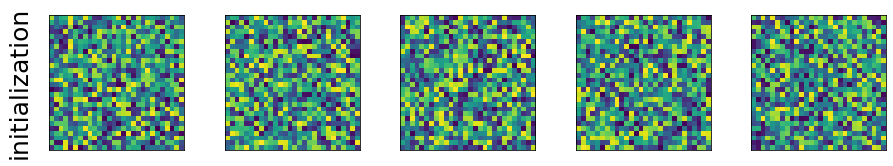

In [14]:
lrs = [3**-2,3**-3,3**-4, 3**-5]

results = load_results()
model = get_model()

mpld3.disable_notebook()
nb_neurons = 5
neurons_per_line = nb_neurons
f, axes = plt.subplots(len(lrs), nb_neurons, 
                       figsize = (nb_neurons*3,len(lrs)*3))
for i,lr in enumerate(lrs):
    model.load_weights('saved_weights_cifar1/'+str(round(lr,6))[2:]+'.h5')
    
    weights = model.get_weights()[0]
    visualize_1stlayer_weights(weights,nb_neurons = nb_neurons, neuron_indices = range(5,10),
                               neurons_per_line = neurons_per_line, axes = axes[i])
    
    pad = -160
    axes[i,-1].annotate(' Train: '+str(round(results[lr]['history']['history']['acc'][-1]*100,2))+'%'+
                        '\n Test: '+str(round(results[lr]['history']['history']['val_acc'][-1]*100,2))+'%', 
                        xy=(0., 0.5), xytext=(-axes[i,-1].yaxis.labelpad - pad, 0.), 
                xycoords=axes[i,-1].yaxis.label, textcoords='offset points', 
                size=25, ha='left', va='center',rotation=0)

plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=-0.3)

plt.savefig('figures/cifar_features_visualization1.png',format='png', dpi=200, bbox_inches="tight")

f, axes = plt.subplots(1, nb_neurons, 
                       figsize = (nb_neurons*3,3))
    
model.load_weights('saved_weights_cifar1/cifar_initial_weights.h5')
weights = model.get_weights()[0]
visualize_1stlayer_weights(weights,nb_neurons = nb_neurons, neuron_indices = range(5,10),
                           neurons_per_line = neurons_per_line, axes = axes)

pad = 10
axes[0].annotate('initialization', xy=(0, 0.5), xytext=(-axes[0].yaxis.labelpad - pad, 0),
            xycoords=axes[0].yaxis.label, textcoords='offset points',
            size=25, ha='right', va='center',rotation=90)

plt.subplots_adjust(wspace=0.3)
# plt.subplots_adjust(hspace=-0.3)


plt.savefig('figures/cifar_initialization_visualization1.png',format='png', dpi=200, bbox_inches="tight")

In [17]:
# ----------------------------------
# 8. Metrics: Accuracy, Precision, Recall, F1, AUC
# ----------------------------------

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
model = get_model()
model.load_weights('saved_weights_cifar1/'+str(round(lr,6))[2:]+'.h5')
y_pred = model.predict(x_test)
y_true = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)


accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
f1 = f1_score(y_true, y_pred_classes, average='macro')
auc = roc_auc_score(y_test, y_pred, multi_class='ovr')


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC:", auc)

Accuracy: 0.3387
Precision: 0.33355208624003946
Recall: 0.33870000000000006
F1 Score: 0.3326865303444105
AUC: 0.7730601555555555
